In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [2]:
data = pd.read_csv('../dataset/dados_pregao_tots3.csv', header=0, parse_dates=True, index_col = 0)
data = data[['preco_ultimo_negocio']]
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')
data

,preco_ultimo_negocio
data_pregao,
2018-01-02,30.15
2018-01-03,30.79
2018-01-04,30.60
2018-01-05,31.26
2018-01-08,31.24
...,...
2024-09-30,28.56
2024-10-01,28.66
2024-10-02,29.45


In [3]:
def grid_search_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(data, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic 
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
            print(f'ARIMA{(p, d, q)} AIC={aic}')
        except:
            continue
    print(f'Melhor Configuração: ARIMA{best_cfg} com AIC={best_score}')
    return best_cfg

In [4]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_order = grid_search_arima(data['preco_ultimo_negocio'], p_values, d_values, q_values)
print(f'Melhor ordem ARIMA: {best_order}')

ARIMA(0, 0, 0) AIC=12877.23354954538
ARIMA(0, 0, 1) AIC=10898.196104969096
ARIMA(0, 0, 2) AIC=9376.943538020918
ARIMA(0, 1, 0) AIC=5372.280163683161
ARIMA(0, 1, 1) AIC=5353.289580637595
ARIMA(0, 1, 2) AIC=5353.533844646108
ARIMA(1, 0, 0) AIC=5378.259026244041
ARIMA(1, 0, 1) AIC=5358.187601166646
ARIMA(1, 0, 2) AIC=5358.756283775729
ARIMA(1, 1, 0) AIC=5354.576466225337
ARIMA(1, 1, 1) AIC=5350.391305945239
ARIMA(1, 1, 2) AIC=5344.779866172498
ARIMA(2, 0, 0) AIC=5359.4026908546
ARIMA(2, 0, 1) AIC=5355.730841545617
ARIMA(2, 0, 2) AIC=5349.812641821528
ARIMA(2, 1, 0) AIC=5355.049889520842
ARIMA(2, 1, 1) AIC=5344.940056610214
ARIMA(2, 1, 2) AIC=5346.397792566713
Melhor Configuração: ARIMA(1, 1, 2) com AIC=5344.779866172498
Melhor ordem ARIMA: (1, 1, 2)


In [5]:
def train_arima(data, order, forecast_periods):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_periods)
    return forecast, model_fit

Tamanho Treino: 1411, Tamanho Teste: 353
Período: 30 dias - RMSE: 0.98, MAPE: 2.59%


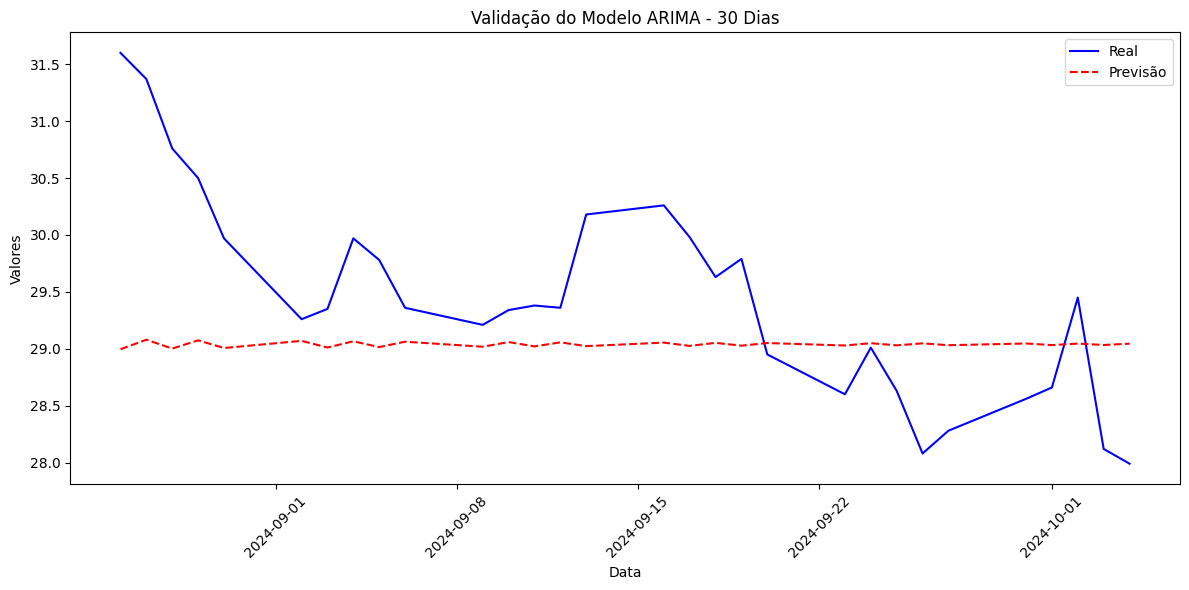

Período: 60 dias - RMSE: 1.10, MAPE: 3.13%


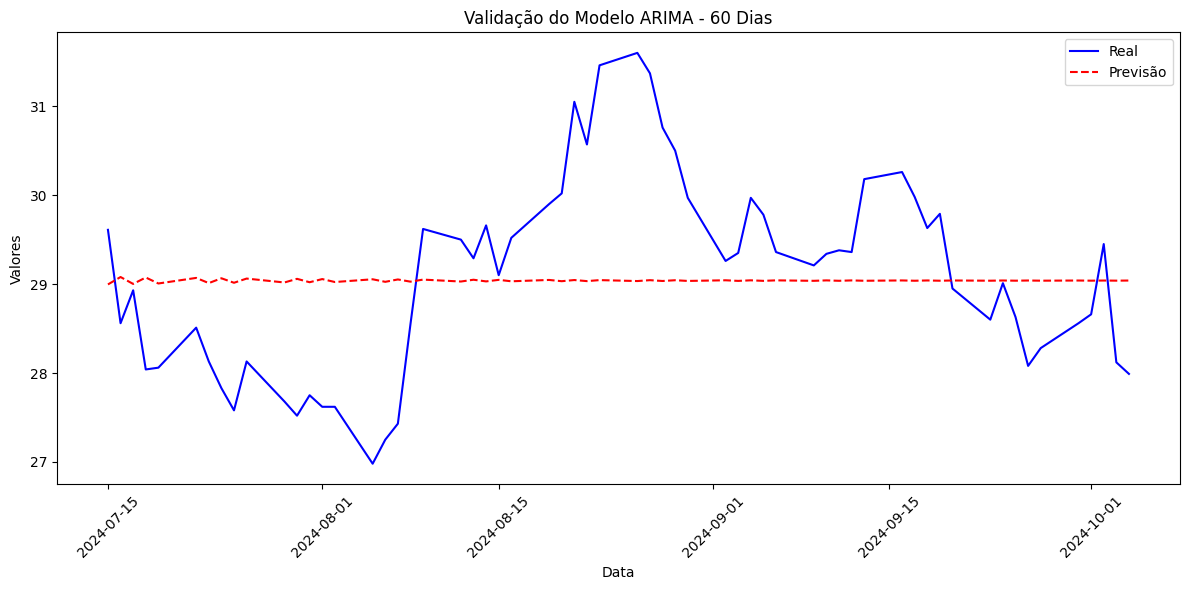

Período: 90 dias - RMSE: 1.04, MAPE: 2.96%


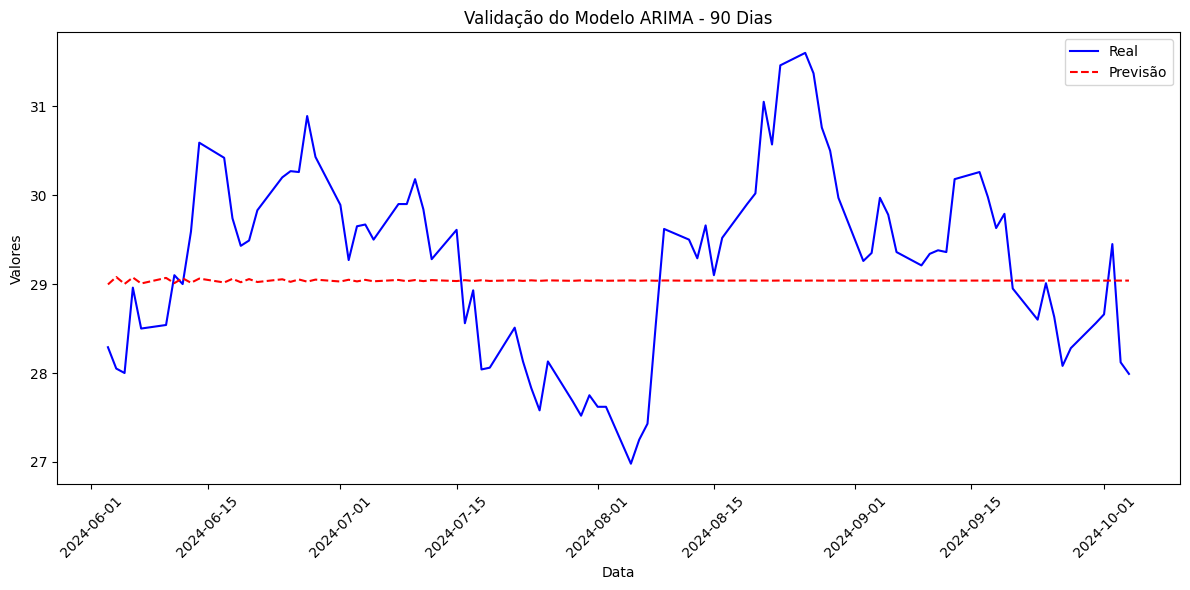

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0 
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

def validate_model(data, order, validation_periods=[30, 60, 90]):

    train_split = int(len(data) * 0.8)
    train_data = data[:train_split]
    test_data = data[train_split:]

    print(f"Tamanho Treino: {len(train_data)}, Tamanho Teste: {len(test_data)}")

    for period in validation_periods:
        if period > len(test_data):
            print(f"Período {period} maior que o conjunto de teste disponível. Skipping.")
            continue

        forecast, _ = train_arima(train_data, order, period)

        test_period_data = test_data[-period:]

        rmse = np.sqrt(mean_squared_error(test_period_data, forecast))
        mape = mean_absolute_percentage_error(test_period_data, forecast)

        print(f'Período: {period} dias - RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

        plt.figure(figsize=(12, 6))
        plt.plot(test_period_data.index, test_period_data, label='Real', color='blue')
        plt.plot(test_period_data.index, forecast, label='Previsão', linestyle='--', color='red')

        plt.title(f'Validação do Modelo ARIMA - {period} Dias')
        plt.xlabel('Data')
        plt.ylabel('Valores')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

validate_model(data['preco_ultimo_negocio'], best_order)

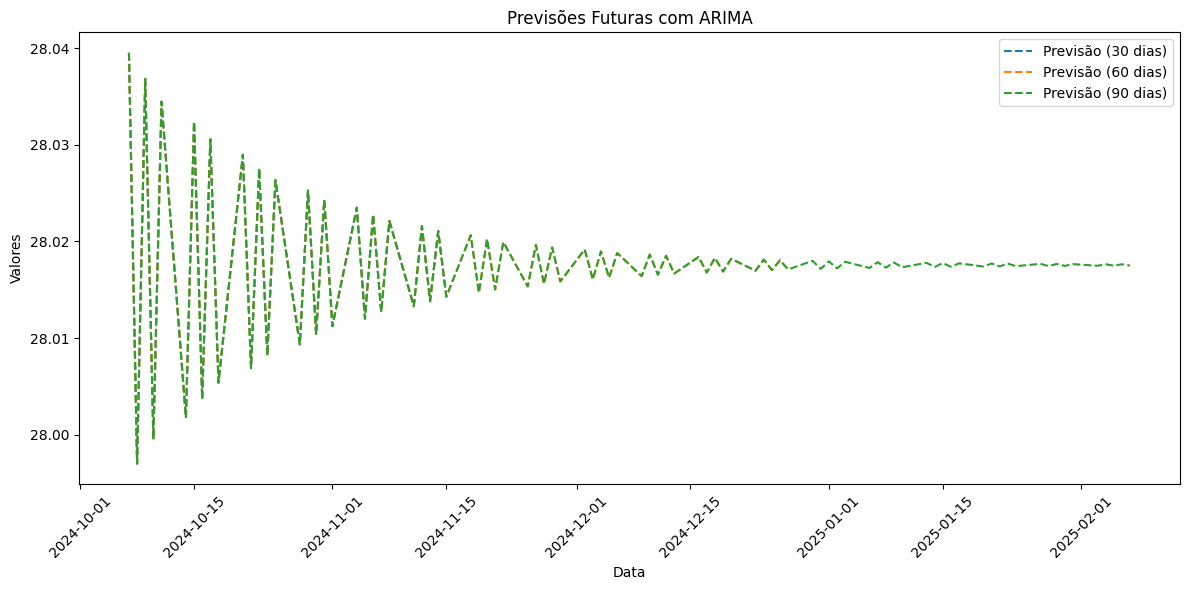

In [7]:
def future_forecast(data, order, future_periods=[30, 60, 90]):
    plt.figure(figsize=(12, 6))

    for period in future_periods:
        forecast, _ = train_arima(data, order, period)
        future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=period, freq='B')

        plt.plot(future_dates, forecast, label=f'Previsão ({period} dias)', linestyle='--')

    plt.title('Previsões Futuras com ARIMA')
    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

future_forecast(data['preco_ultimo_negocio'], best_order)